In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)


c:\Users\Camille\Documents\TWR


In [3]:
import nest_asyncio
nest_asyncio.apply()

from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from utils import show_prompt, format_messages
from app.agents.prompts.system_rules import SYSTEM_RULES
from app.agents.prompts.ml_analist_prompt import *

c:\Users\Camille\Documents\TWR\deep_agents_twr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

In [5]:
show_prompt(SYSTEM_RULES)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  Hard rules:                                                                                                    │
│  - Never invent hashes or traffic sources                                                                       │
│  - Never assume missing information                                                                             │
│  - If the user request is unclear, ask for clarification                                                        │
│  - Do not explain your reasoning to the user                                                                    │
│  - Do not perform analysis or conclusions                                                                       │
│  - Only plan tool execution                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Setting llm model

### Importing the tools

In [6]:
from app.tools.data_tools import query_mongo_requests, query_sql_campaigns

tools = [query_sql_campaigns, query_mongo_requests]

c:\Users\Camille\Documents\TWR\deep_agents_twr\.venv\Lib\site-packages\motor\core.py:171: UserWarning: You appear to be connected to a DocumentDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/documentdb
  delegate = self.__delegate_class__(*args, **kwargs)


In [7]:
await query_sql_campaigns.ainvoke(
    {"traffic_source": "google"}
)

['vz9u93cx3g',
 'riq0ymnvv1',
 'f3qv5v60m1',
 '20udjbfmvf',
 'lrf3cz3ntr',
 'ywq2lx5zqr',
 'xepe4ujfxr',
 'qw5ta0j8nf',
 'anrahnrij4',
 '7jo72t2j87']

In [8]:
from app.tools.data_tools import query_mongo_requests

await query_mongo_requests.ainvoke(
    {"hash": "uw0qfu4a1r", "traffic_source": "google"}
)

{'status': 'success',
 'file_path': 'tool_outputs/mongo_requests_ddf2d203c23d469d9b50a9eb3013852f.json',
 'traffic_source': 'google',
 'count': 1000,
 'preview': [{'_id': ObjectId('698bedc0a265b281ecd89a22'),
   'datetime': datetime.datetime(2026, 2, 11, 2, 47, 26, 451000),
   'decision': 'unsafe',
   'headers': '{"Host":"www.rebeccabonbonloja.com","X-Request-Id":"841b99305f6abad2dfc59c7bab205566","X-Real-Ip":"191.37.159.62","X-Forwarded-For":"191.37.159.62","X-Forwarded-Host":"www.rebeccabonbonloja.com","X-Forwarded-Port":"80","X-Forwarded-Proto":"http","X-Forwarded-Scheme":"http","X-Scheme":"http","X-Original-Forwarded-For":"191.37.159.62, 172.71.11.122","Forwarded":"for=172.71.11.122","Sec-Fetch-Dest":"empty","Referer":"https:\\/\\/rebeccabonbonloja.com\\/","Priority":"u=1, i","Accept-Language":"pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7","Cf-Ray":"9cc08582fc7302ef-GRU","Accept-Encoding":"gzip, br","Sec-Ch-Ua-Platform":"\\"Android\\"","User-Agent":"Mozilla\\/5.0 (Linux; Android 10; K) Appl

In [9]:
from app.tools.data_tools import traffic_source_by_campaign

await traffic_source_by_campaign.ainvoke(
    {"hash": "i5986uszqq"}
)

'Google'

### Agente

### sub-agents

In [10]:
from deepagents import create_deep_agent
from app.tools.data_tools import query_mongo_requests, query_sql_campaigns
from app.tools.ml_tool import *
from app.agents.prompts.ml_analist_prompt import ML_WORKFLOW_INSTRUCTIONS
from app.agents.prompts.deep_agent_prompt import SUBAGENT_DELEGATION_INSTRUCTIONS
from app.agents.ml_analyst_agent import ml_analyst_agent
from langchain_google_genai import ChatGoogleGenerativeAI

In [11]:
from app.agents.prompts.ml_analist_prompt import ML_ANALYST_INSTRUCTIONS

model = ChatGoogleGenerativeAI(
      model="gemini-2.5-flash-lite",
      temperature=0
)

# Gemini 2.5 Flash Lite

INSTRUCTIONS = (
    ML_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS
)


ml_analyst_tools = [
    summarize_misclassifications,
    find_low_trust_samples,
    analyze_user_agent_patterns,
    plot_ml_diagnostics,
    plot_risk_score_distribution,
]

orchestrator_tools = [
    # DB
    query_sql_campaigns,
    query_mongo_requests,
    traffic_source_by_campaign,

    # ML
    run_ml_inference,
    run_ml_noise_analysis,
    prepare_ml_dataframe,
]

ml_analyst_agent = {
    "name": "ml-analyst-agent",
    "description": (
        "Analyze and interpret machine learning inference results. "
        "This sub-agent explains model behavior, investigates misclassifications "
        "and noisy samples, identifies risk patterns in HTTP requests, "
        "and produces evidence-based insights for decision-making. "
        "It focuses on reasoning and analysis, not model training."
    ),
    "system_prompt": ML_ANALYST_INSTRUCTIONS,
    "tools": ml_analyst_tools,
}


agent = create_deep_agent(
      model=model,
      tools=orchestrator_tools,
      system_prompt=INSTRUCTIONS,
      subagents=[ml_analyst_agent]
)

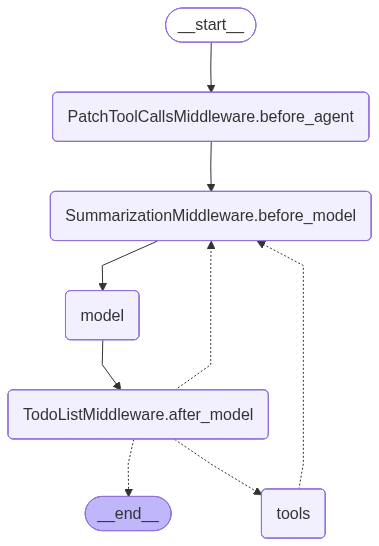

In [12]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [13]:
# result = await agent.ainvoke(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": (
#                     "Analyze recent HTTP requests for traffic_source 'google'. "
#                     "Fetch the most recent active campaigns, load their request logs, "
#                     "run the existing ML model for this traffic source, "
#                     "and investigate misclassifications and noisy samples. "
#                     "Focus on hidden bots (human-labeled but predicted as bot), "
#                     "low mentor trust samples, and suspicious User-Agent patterns. "
#                     "Provide a clear, evidence-based explanation of model behavior."
#                 ),
#             }
#         ],
#     }
# )

# format_messages(result["messages"])


In [14]:
res = await agent.ainvoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Analyze recent HTTP requests for traffic_source 'google'.",
            }
        ],
    }
)

format_messages(res["messages"])

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 21.187338562s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '21s'}]}}

In [ ]:
print(res.keys())

dict_keys(['messages', 'files'])
